In [663]:
import pandas as pd; 
import numpy as np;
from datetime import datetime, date;
import json;
from collections import OrderedDict;
import seaborn as sns;
import matplotlib.pyplot as plt;
from pylab import savefig


# Functions

In [2]:
#Function to merge intervals of time. From https://stackoverflow.com/questions/58570094/pandas-sum-time-interval-in-a-group-excluding-overlaps
def merge_intervals(intervals):
    sorted_by_lower_bound = sorted(intervals, key=lambda tup: tup[0])
    merged = []

    for higher in sorted_by_lower_bound:
        if not merged:
            merged.append(higher)
        else:
            lower = merged[-1]
            # test for intersection between lower and higher:
            # we know via sorting that lower[0] <= higher[0]
            if higher[0] <= lower[1]:
                upper_bound = max(lower[1], higher[1])
                merged[-1] = (lower[0], upper_bound)  # replace by merged interval
            else:
                merged.append(higher)
    return merged

In [ ]:
#-------------------------------------------------Example----------------------------------------------
ids = [x for x in range(10)]
group = [0, 1, 1, 2, 2, 3, 4, 4, 4, 4]

start = pd.to_datetime(["2019-10-21-16:20:00", "2019-10-21-16:22:00", "2019-10-21-16:22:00", "2019-10-21-16:15:00",
         "2019-10-21-16:22:00", "2019-10-21-16:58:00", "2019-10-21-17:02:00", "2019-10-21-17:03:00",
         "2019-10-21-17:04:00", "2019-10-21-17:20:00"])

end = pd.to_datetime(["2019-10-21-16:25:00", "2019-10-21-16:24:00", "2019-10-21-16:24:00", "2019-10-21-16:18:00",
       "2019-10-21-16:26:00", "2019-10-21-17:02:00", "2019-10-21-17:06:00", "2019-10-21-17:07:00",
       "2019-10-21-17:08:00", "2019-10-21-17:22:00"])

cols = ["id", "group", "start", "end"]


df = pd.DataFrame(dict(zip(cols, [ids, group, start, end])))
print(df.head())
# Apply above function
df['dt'] = df[['start', 'end']].apply(tuple, axis=1) #Create a tuple (Date1,Date2)
op = df.groupby(['group'])['dt'].apply(list)  #Create of all intervals grouped.
f_op = op.apply(merge_intervals)   #Use above function to create a grouped list of min,max of each overlaped interval.

op_d = f_op.apply(lambda x: sum([(y[1]-y[0]).seconds for y in x]))
#############################################################################################################################

# Data

## Scenes

In [530]:
df_raw=pd.read_csv("scenes.csv",encoding = "ISO-8859-1",header=1,sep=";")
# dtype={'Selection starts': np.datetime64, 'Selection ends': np.datetime64}

In [531]:
df=df_raw.copy()
df.dtypes

scene               float64
description          object
location             object
sublocation          object
character            object
Selection starts     object
Selection ends       object
Diff.                object
State                object
Movement             object
Note                 object
dtype: object

### Preprocessing

In [ ]:
#df[['Selection starts','Selection ends']]=df[['Selection starts','Selection ends']].astype(str)
#df['Selection starts'].str.split('m').str[0]

In [532]:
#Delete excess rows
df.dropna(axis=0,how="all",inplace=True)
#Create Datetimes
df[['Selection starts','Selection ends']]=df[['Selection starts','Selection ends']].apply(pd.to_datetime)
#Create Date Difference column
df['difference']=df['Selection ends']-df['Selection starts']
df['difference']=df['difference'].dt.seconds

## Characters

In [533]:
ch_raw=pd.read_csv("characters.csv",encoding = "ISO-8859-1",sep=";")

In [534]:
ch=ch_raw.copy()

In [535]:
ch.head()

,Character,Family,Actor,Description,Role,urlImage
0,Ki Woo,Kim,Woo-sik Choi,NaN,English Teacher,https://github.com/javiersgdtu/javiersgvisual/...
1,Ki Jung,Kim,So-dam Park,NaN,Art Teacher,https://github.com/javiersgdtu/javiersgvisual/...
2,Ki Taek,Kim,Kang-ho Song,NaN,Chauffeur,https://github.com/javiersgdtu/javiersgvisual/...
3,Chung Sook,Kim,Hye-jin Jang,NaN,Housekeeper,https://github.com/javiersgdtu/javiersgvisual/...
4,Yeon Kyo,Park,Yeo-jeong Jo,NaN,Mother,https://github.com/javiersgdtu/javiersgvisual/...


# Scenes

## Preprocessing

In [900]:
#Filter Park House
df["location"].value_counts()
df_filt=df[df["location"]=="Park's House"]
df_filt["sublocation"]=df_filt["sublocation"].str.lower()
#Add the level field to the df_filt
df_filt.loc[df_filt["sublocation"].isin(["entrance-street","entrance-intercom","basement","garage","cave"]),"level"]="level0"
df_filt.loc[df_filt["sublocation"].isin(["entrance","kitchen","secondary garden","entrance-stairs","living room","garden","entrance-stairs garage"]),"level"]="level1"
df_filt.loc[df_filt["sublocation"].isin(["da hye's room","mr. & mrs. park room","da song's room","first floor-corridor","toilet","sauna room"]),"level"]="level2"
#df_filt[df_filt["level"].isna()] Chck evertyhing is good

#Add family field to the df_filt
df_filt=df_filt.merge(ch[["Character","Family"]],left_on="character",right_on="Character",how="left")
df_filt.loc[df_filt["character"].isin(["Moon Gwang","Geun Se"]),"Family"]="First"
df_filt.drop(["Character"],axis=1,inplace=True)
#df_filt.head()

C:\Users\Javier San Miguel\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


## General characters insights

In [975]:
#Get scene duration in Park House.
#This is the first time we use the merge_intervals function. There might be shorter ways of calculating it. I just wanted to
#use this method.
df_filt['dt_sub'] = df_filt[['Selection starts', 'Selection ends']].apply(tuple, axis=1) #Create a tuple (Date1,Date2)
#scene_selection = df_filt.groupby(["character"])['dt_sub'].apply(list)  #Create of all intervals grouped.
#scene_selection = df_filt.groupby(["Family"])['dt_sub'].apply(list)  #Create of all intervals grouped.
#scene_selection = df_filt.groupby(["Family","scene","level"])['dt_sub'].apply(list)  #Create of all intervals grouped.
scene_selection = df_filt.groupby(["character","sublocation"])['dt_sub'].apply(list)

f_scene_selection = scene_selection.apply(merge_intervals)   #Use above function to create a grouped list of min,max of each overlaped interval.

time_scene = pd.DataFrame(f_scene_selection.apply(lambda x: sum([(y[1]-y[0]).seconds for y in x])))
time_scene.reset_index(inplace=True)

In [981]:
time_gr=time_scene.groupby(['sublocation',"character"]).agg({'dt_sub': 'sum'})
# Change: groupby state_office and divide by sum
time_gr = time_gr.groupby(["sublocation"]).apply(lambda x:
                                                 100 * x / float(x.sum()))
time_gr.sort_values(["sublocation","dt_sub"],ascending=[False,False],inplace=True)

In [993]:
pd.set_option('display.max_rows', 100)

time_gr.tail(100)

dt_sub
sublocation            character                  
living room            Yeon Kyo           8.037119
                       Mr. Park           5.709343
                       Moon Gwang         5.111670
                       Geun Se            4.325260
                       Da Hye             0.943693
                       Da Song            0.707770
kitchen                Yeon Kyo          32.454512
                       Chung Sook        23.988117
                       Ki Jung           10.397326
                       Mr. Park           9.283327
                       Ki Woo             6.981062
                       Moon Gwang         6.349796
                       Ki Taek            4.678797
                       Da Song            3.230598
                       Da Hye             1.633866
                       Geun Se            1.002599
garden                 Da Song           21.425097
                       Party attendants  15.856031
                       Ki Taek           14.567121
                       Mr. Park          13.351167
                       Yeon Kyo          10.919261
                       Ki Jung           10.238327
                       Chung Sook         6.517510
                       Geun Se            3.137160
                       Ki Woo             3.064202
                       Moon Gwang         0.826848
                       Da Hye             0.097276
garage                 Ki Taek           15.873016
                       Yeon Kyo          15.873016
                       Chung Sook        14.285714
                       Da Hye            11.111111
                       Da Song           11.111111
                       Ki Jung           11.111111
                       Mr. Park          11.111111
                       Ki Woo             9.523810
first floor-corridor   Yeon Kyo          34.821429
                       Da Hye            21.428571
                       Ki Woo            19.642857
                       Ki Jung            8.928571
                       Chung Sook         8.035714
                       Moon Gwang         5.357143
                       Da Song            1.785714
entrance-street        Moon Gwang        25.626741
                       Ki Jung           25.348189
                       Yeon Kyo          23.955432
                       Ki Woo            15.041783
                       Ki Taek            6.685237
                       Party attendants   3.342618
entrance-stairs garage Ki Jung           26.108374
                       Ki Woo            26.108374
                       Ki Taek           15.763547
                       Yeon Kyo          12.807882
                       Mr. Park          10.344828
                       Da Hye             4.926108
                       Da Song            1.970443
                       First chaufer      1.970443
entrance-stairs        Da Hye            34.806630
                       Da Song           18.232044
                       Ki Jung           18.232044
                       Ki Woo             9.392265
                       Ki Taek            6.629834
                       Yeon Kyo           5.524862
                       Mr. Park           4.972376
                       Chung Sook         2.209945
entrance-intercom      Moon Gwang        34.909091
                       Ki Woo            31.272727
                       Ki Jung           17.454545
                       Yeon Kyo          16.363636
entrance               Chung Sook        25.937500
                       Yeon Kyo          19.687500
                       Ki Woo            17.031250
                       Moon Gwang        13.281250
                       Ki Jung            5.781250
                       Mr. Park           5.000000
                       First chaufer      4.062500
                       Da Song            3.750000
                       Ki Taek            3.750000
               

### Evolution of ocupation by family of House levels.

In [960]:
#Evolution of ocupation by family of House levels.

#and above.
#scene_selection = df_filt.groupby(["Family","scene","level"])['dt_sub'].apply(list)  #Create of all intervals grouped.

time_gr=time_scene.groupby(["scene",'level',"Family"]).agg({'dt_sub': 'sum'})
# Change: groupby state_office and divide by sum
time_gr = time_gr.groupby(["scene","level"]).apply(lambda x:
                                                 100 * x / float(x.sum()))
time_gr

dt_sub
scene level  Family            
3.0   level0 Kim      73.118280
             Park     26.881720
      level1 First    24.000000
             Kim      41.935484
             Park     34.064516
      level2 Kim      47.761194
             Park     52.238806
4.0   level0 First    42.424242
             Kim      33.333333
             Park     24.242424
      level1 First    13.780261
             Kim      41.340782
             Park     44.878957
      level2 Kim      50.000000
             Park     50.000000
5.0   level0 First    27.611940
             Kim      37.313433
             Park     35.074627
      level1 Kim      21.343874
             Park     78.656126
6.0   level0 First    52.941176
             Kim      29.411765
             Park     17.647059
      level1 First    32.142857
             Kim      35.000000
             Park     32.857143
      level2 First     6.209150
             Kim      47.712418
             Park     46.078431
7.0   level0 Kim      53.333333
             Park     46.666667
      level1 Kim      85.576923
             Park     14.423077
      level2 Kim      91.304348
             Park      8.695652
8.0   level0 First    50.791917
             Kim      49.208083
      level1 First    13.467294
             Kim      56.092347
             Park     30.440359
      level2 Kim      50.173812
             Park     49.826188
9.0   level0 First    54.862385
             Kim      42.935780
             Park      2.201835
      level1 First    10.600945
             Kim      40.783255
             Park     48.615800
      level2 Kim      38.403042
             Park     61.596958
10.0  level0 Kim     100.000000
      level1 Kim     100.000000

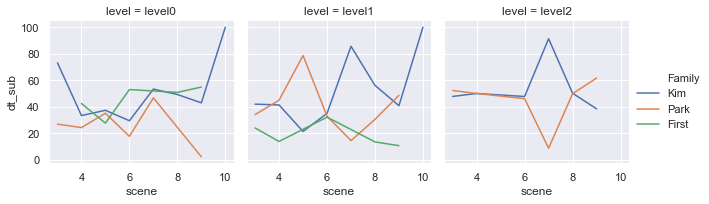

In [961]:
time_gr.sort_values(["level","scene","dt_sub"],ascending=[False,True,False])
time_gr.reset_index(inplace=True)
fig=sns.relplot(x="scene", y="dt_sub", hue="Family",
            col="level", height=3,
            kind="line", estimator=None, data=time_gr);

## Force layout

There are 3 main variables displayed in the force layout: Character,Duration in each sublocation & movement in this scene

In [519]:
#All the duration of characters in the same scene+sublocation should be grouped.
df_gr=df_filt.groupby(["scene","character","sublocation"],as_index=False).agg({"difference":"sum","Movement":lambda x: ','.join(x)})

#Remove duplicates of column Movement after concatenation
#df_gr["Movement"]=[','.join(set(j["Movement"].split(','))) for i,j in df_gr.iterrows()] //alphabetical order
df_gr["Movement"]=[",".join(OrderedDict.fromkeys(j["Movement"].split(','))) for i,j in df_gr.iterrows()]

In [69]:
df_gr.head(15)

,scene,character,sublocation,difference,Movement
0,3.0,Da Hye,da hye's room,87,Static
1,3.0,Da Song,entrance,17,Move
2,3.0,Da Song,entrance-stairs,9,Down
3,3.0,Da Song,garden,34,Move
4,3.0,Da Song,living room,35,Move
5,3.0,Ki Woo,da hye's room,87,Static
6,3.0,Ki Woo,entrance,94,"Move,Down"
7,3.0,Ki Woo,entrance-intercom,43,"Up,Move,Down"
8,3.0,Ki Woo,entrance-stairs,8,Up
9,3.0,Ki Woo,entrance-street,25,"Move,Up,Down"


In [520]:
df_gr.head(50)
print(df_gr.dtypes)
df_gr.difference.describe()

scene          float64
character       object
sublocation     object
difference       int64
Movement        object
dtype: object


count     248.000000
mean       87.060484
std       164.295405
min         1.000000
25%         9.000000
50%        22.000000
75%        74.000000
max      1110.000000
Name: difference, dtype: float64

In [521]:
#replace some characters to match the name of the center elements in the svg
df_gr["sublocation"].replace(" ",'_',regex=True,inplace=True)
df_gr["sublocation"].replace('&','',regex=True,inplace=True)
df_gr["sublocation"].replace('\\._','_',regex=True,inplace=True)
df_gr["sublocation"].replace("'",'_',regex=True,inplace=True)

In [522]:
#Get scene duration in Park House.
#This is the first time we use the merge_intervals function. There might be shorter ways of calculating it. I just wanted to
#use this method.
df_filt['dt_sub'] = df_filt[['Selection starts', 'Selection ends']].apply(tuple, axis=1) #Create a tuple (Date1,Date2)
scene_selection = df_filt.groupby(["scene"])['dt_sub'].apply(list)  #Create of all intervals grouped.
f_scene_selection = scene_selection.apply(merge_intervals)   #Use above function to create a grouped list of min,max of each overlaped interval.

time_scene = pd.DataFrame(f_scene_selection.apply(lambda x: sum([(y[1]-y[0]).seconds for y in x])))
time_scene.reset_index(inplace=True)

In [523]:
#check=df_filt[df_filt["sublocation"].isin(["garden","entrance","basement"])]
df_gr=df_gr[~df_gr["sublocation"].isin(["toilet","sauna_room"])]#,"entrance-intercom"
df_gr.sublocation.value_counts()

kitchen                   35
living_room               29
entrance                  29
garden                    23
entrance-stairs           18
entrance-stairs_garage    15
da_hye_s_room             14
basement                  13
entrance-street           13
garage                    11
first_floor-corridor      11
cave                      10
entrance-intercom          8
da_song_s_room             6
secondary_garden           4
mr__mrs_park_room          4
Name: sublocation, dtype: int64

In [525]:
#Merge df_gr with time_scene.
df_gr=time_scene.merge(df_gr,on="scene")

In [208]:
df_gr.to_json("data_out/scenes.json",orient='records');
#check.to_json("data_out/scenes.json",orient='records');

In [529]:
time_scene.to_json("data_out/time_scene.json",orient='records');

## Movement insights

 Interesting analysis to address:
 * See what family moves the most up/down (UP and down) and who is more static
 * Character the longest in the film
 * Sevice woman
 * Character the longest static
 * Who occupies the lower and upper floors the most

In [1136]:
df_filt["Movement"]=df_filt["Movement"].str.lower()

In [1200]:
#Filter specific movement.
df_move= df_filt[df_filt["Movement"].str.contains("move")]#down,static,move
#df_move=df_move.groupby(["scene","character","level"],as_index=False).agg({"difference":"sum"})
df_move=df_move.groupby(["scene","Family","level"],as_index=False).agg({"difference":"sum"})
#df_move=df_move.groupby(["scene","character"],as_index=False).agg({"difference":"sum"})
#df_move=df_move.groupby(["scene","Family"],as_index=False).agg({"difference":"sum"})
df_move.rename({"difference":"move_time"},axis=1,inplace=True)

#How much time does every character appears in a scene:
#df_character_scene=df_filt.groupby(["scene","character","level"],as_index=False).agg({"difference":"sum"})
df_character_scene=df_filt.groupby(["scene","Family","level"],as_index=False).agg({"difference":"sum"})
#df_character_scene=df_filt.groupby(["scene","character"],as_index=False).agg({"difference":"sum"})
#df_character_scene=df_filt.groupby(["scene","Family"],as_index=False).agg({"difference":"sum"})
df_character_scene.rename({"difference":"scene_time"},axis=1,inplace=True)

#Merge.
#df_move_mg=df_move.merge(df_character_scene,on=["scene","character","level"],how="right")
df_move_mg=df_move.merge(df_character_scene,on=["scene","Family","level"],how="right")
#df_move_mg=df_move.merge(df_character_scene,on=["scene","character"],how="right")
#df_move_mg=df_move.merge(df_character_scene,on=["scene","Family"],how="right")

df_move_mg.fillna(0,inplace=True)
df_move_mg["pct"] = np.round(100*(df_move_mg["move_time"] / df_move_mg["scene_time"]),1)
df_move_mg.sort_values(["scene","move_time"],ascending=[True,False],inplace=True)
# To see how much time per scene a character is moving in a specific direction.
df_move_mg

,scene,Family,level,move_time,scene_time,pct
2,3.0,Kim,level1,288.0,325,88.6
5,3.0,Park,level1,220.0,359,61.3
0,3.0,First,level1,186.0,186,100.0
1,3.0,Kim,level0,40.0,68,58.8
4,3.0,Park,level0,25.0,25,100.0
3,3.0,Kim,level2,9.0,96,9.4
6,3.0,Park,level2,9.0,192,4.7
10,4.0,Kim,level2,234.0,234,100.0
12,4.0,Park,level1,229.0,357,64.1
8,4.0,First,level1,74.0,74,100.0


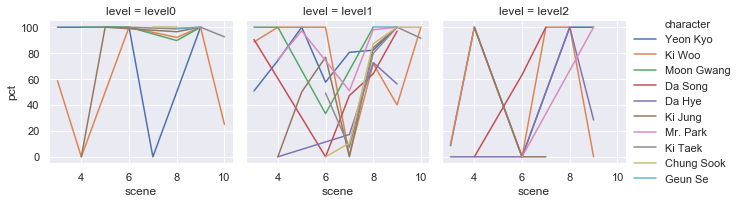

In [1135]:
df_move_mg=df_move_mg[~df_move_mg["character"].isin(["Party attendants","First chaufer"])]

fig=sns.relplot(x="scene", y="pct", hue="character",#hue_order=["level2","level0","level1"],
            col="level", height=3,
            kind="line", estimator=None, data=df_move_mg);

In [1050]:
#fig.savefig('C:/Users/Javier San Miguel/Desktop/Data/Data visualization/Parasite/doc/img/movementMoveFamily.png',dpi=200)

In [ ]:
df_character_scene.head(10)

In [1201]:
#df_move_mg.sort_values(["scene","pct"],ascending=[True,False],inplace=True)
df_move_mg.sort_values(["scene","level","pct"],ascending=[True,True,False],inplace=True)
df_move_mg.head(10)

,scene,Family,level,move_time,scene_time,pct
4,3.0,Park,level0,25.0,25,100.0
1,3.0,Kim,level0,40.0,68,58.8
0,3.0,First,level1,186.0,186,100.0
2,3.0,Kim,level1,288.0,325,88.6
5,3.0,Park,level1,220.0,359,61.3
3,3.0,Kim,level2,9.0,96,9.4
6,3.0,Park,level2,9.0,192,4.7
7,4.0,First,level0,28.0,28,100.0
11,4.0,Park,level0,16.0,16,100.0
49,4.0,Kim,level0,0.0,44,0.0


In [1202]:
#Across the film.
#df_move_film=df_move_mg.groupby(["character","level"],as_index=False).agg({"move_time":"sum","scene_time":"sum"})
df_move_film=df_move_mg.groupby(["Family","level"],as_index=False).agg({"move_time":"sum","scene_time":"sum"})

df_move_film["pct"] = np.round(100*(df_move_film["move_time"] / df_move_film["scene_time"]),1)
df_move_film.sort_values(["move_time"],ascending=False,inplace=True)
df_move_film

,Family,level,move_time,scene_time,pct
4,Kim,level1,4930.0,7973,61.8
7,Park,level1,3817.0,4530,84.3
3,Kim,level0,2363.0,2515,94.0
0,First,level0,2112.0,2214,95.4
1,First,level1,1030.0,1090,94.5
5,Kim,level2,800.0,1061,75.4
8,Park,level2,640.0,1272,50.3
6,Park,level0,153.0,223,68.6
2,First,level2,19.0,19,100.0


In [1203]:
df_move_film.sort_values(["level","pct"],ascending=False,inplace=True)
df_move_film

,Family,level,move_time,scene_time,pct
2,First,level2,19.0,19,100.0
5,Kim,level2,800.0,1061,75.4
8,Park,level2,640.0,1272,50.3
1,First,level1,1030.0,1090,94.5
7,Park,level1,3817.0,4530,84.3
4,Kim,level1,4930.0,7973,61.8
0,First,level0,2112.0,2214,95.4
3,Kim,level0,2363.0,2515,94.0
6,Park,level0,153.0,223,68.6


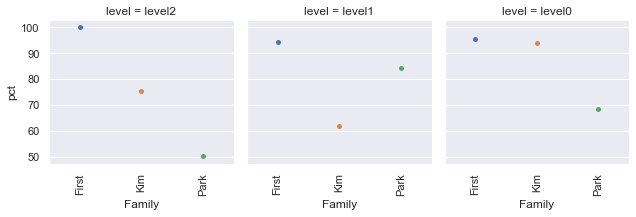

In [1205]:
#df_move_film=df_move_film[~df_move_film["character"].isin(["Party attendants","First chaufer"])]
fig=sns.catplot(x="Family", y="pct", 
            col="level", height=3,
            kind="swarm", estimator=None, data=df_move_film);
fig.set_xticklabels(rotation=90)


In [1133]:
fig.savefig('C:/Users/Javier San Miguel/Desktop/Data/Data visualization/Parasite/doc/img/filmmovementMoveCharacter.png',dpi=200)

In [1206]:
# Movement time / SUM of total movement  of this floor of any character/family
sum_pd=df_move_film.groupby("level",as_index=False).agg({"move_time":"sum"})
sum_pd.rename({"move_time":"sumlevel"},axis=1,inplace=True)
df_move_film_mg=sum_pd.merge(df_move_film, on="level")
df_move_film_mg["pct"] = np.round(100*(df_move_film_mg["move_time"] / df_move_film_mg["sumlevel"]),1)
df_move_film_mg
#pd.DataFrame(df_move_film.groupby("level").apply(lambda x: x["move_time"] / x["scene_time"].sum()))


,level,sumlevel,Family,move_time,scene_time,pct
0,level0,4628.0,First,2112.0,2214,45.6
1,level0,4628.0,Kim,2363.0,2515,51.1
2,level0,4628.0,Park,153.0,223,3.3
3,level1,9777.0,First,1030.0,1090,10.5
4,level1,9777.0,Park,3817.0,4530,39.0
5,level1,9777.0,Kim,4930.0,7973,50.4
6,level2,1459.0,First,19.0,19,1.3
7,level2,1459.0,Kim,800.0,1061,54.8
8,level2,1459.0,Park,640.0,1272,43.9


## Movement Viz

In [ ]:
# Something to fix here, as we use explode, there are duplicates when classifying up|down and representing by movement_class

In [1010]:
#All the duration of characters in the same scene+sublocation should be grouped.
df_filt["Movement"]=df_filt["Movement"].str.lower()
#Get duration in each scene & level /character.
df_gr=df_filt.groupby(["scene","character","level","Family"],as_index=False).agg({"difference":"sum"})
df_gr.rename({"difference":"scene_level_time"},axis=1,inplace=True)

In [996]:
#Explode=separate string Movement into rows.
df_explo=df_filt.assign(Movement_dup=df_filt['Movement'].str.split(',')).explode('Movement_dup')
df_explo.rename({"difference":"move_time"},axis=1,inplace=True)
#Classify column
df_explo["Movement_class"]=df_explo["Movement_dup"]
df_explo.loc[df_explo["Movement_dup"].isin(["up","down"]),"Movement_class"]="up|down"

#group scenes,level,character & movement dup. There can be characters with
#several same moves per scene/level that need to be grouped
df_explo=df_explo.groupby(["scene","character","level","Movement_dup"],as_index=False).agg({"move_time":"sum","Movement_class":"first"})
df_explo=df_explo.groupby(["scene","character","level","Movement_class"],as_index=False).agg({"move_time":"first"})

In [997]:
#groupby to see time going up down per level,sublocation, character
df_mg=df_gr.merge(df_explo,on=["scene","character","level"])

df_mg["pct"] = np.round(100*(df_mg["move_time"] / df_mg["scene_level_time"]),1)
#df_mg.sort_values(["scene","level","Movement_dup","pct"],ascending=[True,True,True,False],inplace=True)
df_mg.sort_values(["scene","level","Movement_class","pct"],ascending=[True,True,True,False],inplace=True)

In [998]:
df_mg.head(30)

,scene,character,level,Family,scene_level_time,Movement_class,move_time,pct
11,3.0,Yeon Kyo,level0,Park,25,move,25,100.0
3,3.0,Ki Woo,level0,Kim,68,move,40,58.8
12,3.0,Yeon Kyo,level0,Park,25,up|down,25,100.0
4,3.0,Ki Woo,level0,Kim,68,up|down,25,36.8
10,3.0,Moon Gwang,level1,First,186,move,186,100.0
1,3.0,Da Song,level1,Park,95,move,86,90.5
5,3.0,Ki Woo,level1,Kim,325,move,288,88.6
13,3.0,Yeon Kyo,level1,Park,264,move,134,50.8
14,3.0,Yeon Kyo,level1,Park,264,static,213,80.7
6,3.0,Ki Woo,level1,Kim,325,static,223,68.6


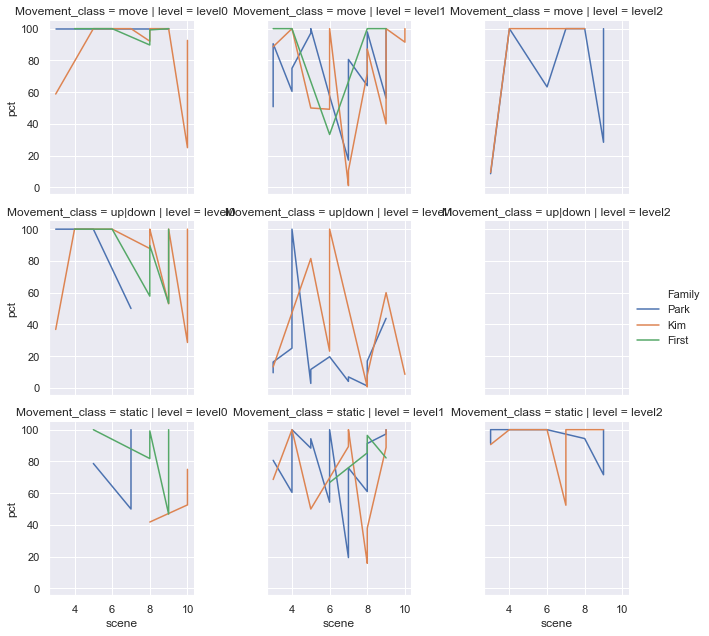

In [866]:
#df_mg_ft=df_mg[df_mg["Movement_dup"]!="hiding"]
df_mg_ft=df_mg[df_mg["Movement_class"]!="hiding"]

df_mg_ft=df_mg_ft[~df_mg_ft["character"].isin(["Party attendants","First chaufer"])]

fig=sns.relplot(x="scene", y="pct", hue="Family",
            col="level", row="Movement_class", height=3,
            kind="line", estimator=None, data=df_mg_ft);

In [867]:
fig.savefig('C:/Users/Javier San Miguel/Desktop/Data/Data visualization/Parasite/doc/img/familymovementline.png',dpi=200)

### Insights from Viz

In [873]:
df_mg.head(20)

,scene,character,level,Family,scene_level_time,Movement_class,move_time,pct
11,3.0,Yeon Kyo,level0,Park,25,move,25,100.0
3,3.0,Ki Woo,level0,Kim,68,move,40,58.8
12,3.0,Yeon Kyo,level0,Park,25,up|down,25,100.0
4,3.0,Ki Woo,level0,Kim,68,up|down,25,36.8
10,3.0,Moon Gwang,level1,First,186,move,186,100.0
1,3.0,Da Song,level1,Park,95,move,86,90.5
5,3.0,Ki Woo,level1,Kim,325,move,288,88.6
13,3.0,Yeon Kyo,level1,Park,264,move,134,50.8
14,3.0,Yeon Kyo,level1,Park,264,static,213,80.7
6,3.0,Ki Woo,level1,Kim,325,static,223,68.6


In [898]:
df_mg[df_mg.pct>50]
#groupby(["scene","level","Movement_class"]).#filter(lambda x: (x['pct'] > 50).any())
#["pct"].agg({"pct":"first","character":"first","Family":"first"})

,scene,character,level,Family,scene_level_time,Movement_class,move_time,pct
11,3.0,Yeon Kyo,level0,Park,25,move,25,100.0
3,3.0,Ki Woo,level0,Kim,68,move,40,58.8
12,3.0,Yeon Kyo,level0,Park,25,up|down,25,100.0
10,3.0,Moon Gwang,level1,First,186,move,186,100.0
1,3.0,Da Song,level1,Park,95,move,86,90.5
...,...,...,...,...,...,...,...,...
208,10.0,Ki Taek,level0,Kim,175,static,92,52.6
214,10.0,Ki Woo,level0,Kim,28,up|down,28,100.0
206,10.0,Chung Sook,level1,Kim,79,move,79,100.0
215,10.0,Ki Woo,level1,Kim,79,move,79,100.0


In [889]:
result=pd.DataFrame(grouped.apply(
    lambda x:  x['pct'] - x['pct'].shift()>20))

In [890]:
result

pct
scene level  Movement_class           
3.0   level0 move           11   False
                            3    False
             up|down        12   False
                            4    False
      level1 move           10   False
...                                ...
10.0  level0 up|down        209  False
      level1 move           206  False
                            215  False
                            210  False
             up|down        211  False

[216 rows x 1 columns]

# Locations in the film

Due to the DB schema there are moments in the film where characters are in different locations and counted in both of them. Though the Date of an opening character in a scene and the closing one are the first and last moments in which the location appears. 

In [536]:
df_loc=df.copy()
df_loc.head(10)

,scene,description,location,sublocation,character,Selection starts,Selection ends,Diff.,State,Movement,Note,difference
0,0.0,initial Credits,NaN,NaN,NaN,2020-11-16 00:00:00,2020-11-16 00:00:45,0:00:45,NaN,NaN,NaN,45
1,1.0,Family Introduction -No Wifi,Kim's House,Living room,Ki Woo,2020-11-16 00:00:45,2020-11-16 00:01:40,0:00:55,NaN,NaN,NaN,55
2,1.0,Family Introduction -No Wifi,Kim's House,Corridor,Ki Woo,2020-11-16 00:01:40,2020-11-16 00:02:10,0:00:30,NaN,NaN,NaN,30
3,1.0,Ki Taek quicks insect,Kim's House,Living room,Ki Woo,2020-11-16 00:02:14,2020-11-16 00:02:20,0:00:06,NaN,NaN,NaN,6
4,1.0,NaN,Kim's House,Corridor,Ki Woo,2020-11-16 00:02:20,2020-11-16 00:02:24,0:00:04,NaN,NaN,NaN,4
5,1.0,Wifi in the toilet,Kim's House,Bathroom,Ki Woo,2020-11-16 00:02:34,2020-11-16 00:03:03,0:00:29,NaN,NaN,NaN,29
6,1.0,Wifi in the toilet,Kim's House,Corridor,Ki Woo,2020-11-16 00:03:03,2020-11-16 00:03:06,0:00:03,NaN,NaN,NaN,3
7,1.0,Family Introduction -No Wifi,Kim's House,Bathroom,Ki Jung,2020-11-16 00:00:45,2020-11-16 00:01:42,0:00:57,NaN,NaN,NaN,57
8,1.0,Family Introduction -No Wifi,Kim's House,Corridor,Ki Jung,2020-11-16 00:01:42,2020-11-16 00:01:46,0:00:04,NaN,NaN,NaN,4
9,1.0,Family Introduction -No Wifi,Kim's House,Room I,Ki Jung,2020-11-16 00:01:46,2020-11-16 00:02:10,0:00:24,NaN,NaN,NaN,24


In [538]:
#Second method. Without locationid
df_loc['dt'] = df_loc[['Selection starts', 'Selection ends']].apply(tuple, axis=1) #Create a tuple (Date1,Date2)
list_selection = df_loc.groupby(["location"])['dt'].apply(list)  #Create of all intervals grouped.
f_list_selection = list_selection.apply(merge_intervals)   #Use above function to create a grouped list of min,max of each overlaped interval.

time_locat = pd.DataFrame(f_list_selection.apply(lambda x: sum([(y[1]-y[0]).seconds for y in x])))
time_locat.reset_index(inplace=True)

In [539]:
time_loc=time_locat.groupby("location").agg({"dt":"sum"})
time_loc["pct"] = time_loc.apply(lambda x:np.round(100 * x / x.sum(),1))
#time_loc
time_loc=time_loc.reset_index().sort_values("pct",ascending=False)
time_loc

,location,dt,pct
12,Park's House,5259,65.8
9,Kim's House,884,11.1
11,Mr.Park's car,477,6.0
17,Stadium,245,3.1
18,Street by Kim's house,224,2.8
6,Grocery shop,181,2.3
15,Seoul streets,173,2.2
10,Mr's Park Office,145,1.8
7,Hospital,83,1.0
16,Shopping Mall,73,0.9


In [540]:
#Grouping similar numbers.
time_loc.loc[~time_loc.location.isin(["Park's House","Kim's House","Mr.Park's car","Street by Kim's house","Stadium"]),"location"]="Other Seoul locations"
time_loc.loc[time_loc.location.isin(["Kim's House","Street by Kim's house"]),"location"]="Kim's House"

In [541]:
time_loc=time_loc.groupby("location",as_index=True).agg({"pct":"sum"})
time_loc

,pct
location,
Kim's House,13.9
Mr.Park's car,6.0
Other Seoul locations,11.5
Park's House,65.8
Stadium,3.1


## Sublocations in Park House

In [579]:
df_loc_filt=df_filt.copy()
#df_loc_filt=df[df["location"]=="Park's House"]
df_loc_filt_dup=df_loc_filt.copy()

In [580]:
#The dataset created locates each character in the point that they are staying
#(when this information is provided) rather than their time in screen.
df_loc_filt_dup.sort_values("difference",ascending=False).head(20)

,scene,description,location,sublocation,character,Selection starts,Selection ends,Diff.,State,Movement,Note,difference,level,Family
203,8.0,Kim family attack + peach inoculation,Park's House,living room,Ki Jung,2020-11-16 01:15:11,2020-11-16 01:30:52,0:15:41,NaN,"Move,Hiding",NaN,941,level1,Kim
300,9.0,Kevin and Da Hye: Do i fit here?,Park's House,garden,Party attendants,2020-11-16 01:45:09,2020-11-16 01:56:01,0:10:52,NaN,"Move,Static",NaN,652,level1,NaN
301,9.0,Kevin and Da Hye: Do i fit here?,Park's House,garden,Da Song,2020-11-16 01:45:09,2020-11-16 01:56:01,0:10:52,We don't see him but know he is there.,"Static,Move",NaN,652,level1,Park
304,9.0,Dressing as indians to surprise to Da Song,Park's House,garden,Ki Taek,2020-11-16 01:46:50,2020-11-16 01:56:01,0:09:11,NaN,"Static,Move",NaN,551,level1,Kim
169,7.0,Drinking+ someone calls,Park's House,living room,Ki Woo,2020-11-16 00:56:31,2020-11-16 01:05:07,0:08:36,NaN,Static,NaN,516,level1,Kim
168,7.0,Drinking+ someone calls,Park's House,living room,Ki Taek,2020-11-16 00:56:31,2020-11-16 01:05:07,0:08:36,NaN,Static,NaN,516,level1,Kim
170,7.0,Drinking+ someone calls,Park's House,living room,Ki Jung,2020-11-16 00:56:31,2020-11-16 01:05:07,0:08:36,NaN,Static,NaN,516,level1,Kim
305,9.0,Dressing as indians to surprise to Da Song,Park's House,garden,Mr. Park,2020-11-16 01:46:50,2020-11-16 01:55:10,0:08:20,death,"Static,Move",NaN,500,level1,Park
213,8.0,Preparing Ram Don + locking Geun Se and Moon G...,Park's House,cave,Geun Se,2020-11-16 01:16:54,2020-11-16 01:24:14,0:07:20,When Ki Taek leaves the cave. 1:49:21 till las...,"Down,Move,Static",NaN,440,level0,First
225,8.0,Bringing back diary to Da Hye + hiding in her ...,Park's House,da hye's room,Ki Woo,2020-11-16 01:17:53,2020-11-16 01:24:55,0:07:02,NaN,"Move,Hiding",NaN,422,level2,Kim


In [581]:
df_loc_filt_dup['dt_sub'] = df_loc_filt_dup[['Selection starts', 'Selection ends']].apply(tuple, axis=1) #Create a tuple (Date1,Date2)
list_selection = df_loc_filt_dup.groupby(["sublocation"])['dt_sub'].apply(list)  #Create of all intervals grouped.
f_list_selection = list_selection.apply(merge_intervals)   #Use above function to create a grouped list of min,max of each overlaped interval.

time_locat = pd.DataFrame(f_list_selection.apply(lambda x: sum([(y[1]-y[0]).seconds for y in x])))
time_locat.reset_index(inplace=True)

In [582]:
print(time_locat.dt_sub.sum())
time_locat.sort_values("dt_sub",ascending=False)

8202


,sublocation,dt_sub
13,living room,1941
12,kitchen,1439
1,cave,1168
11,garden,1025
2,da hye's room,858
4,entrance,421
0,basement,337
5,entrance-intercom,218
8,entrance-street,166
6,entrance-stairs,155


In [583]:
time_subloc=time_locat.groupby("sublocation").agg({"dt_sub":"sum"})
time_subloc["pct_sub"] = time_subloc.apply(lambda x:np.round(100 * x / x.sum(),1))
#time_subloc
time_subloc=time_subloc.reset_index().sort_values("pct_sub",ascending=False)
time_subloc["location"]="Park's House"

In [584]:
time_subloc

,sublocation,dt_sub,pct_sub,location
13,living room,1941,23.7,Park's House
12,kitchen,1439,17.5,Park's House
1,cave,1168,14.2,Park's House
11,garden,1025,12.5,Park's House
2,da hye's room,858,10.5,Park's House
4,entrance,421,5.1,Park's House
0,basement,337,4.1,Park's House
5,entrance-intercom,218,2.7,Park's House
8,entrance-street,166,2.0,Park's House
6,entrance-stairs,155,1.9,Park's House


## Merge

In [433]:
time_loc_merg=time_loc.merge(time_subloc,on="location",how="left")
time_loc_merg

,location,pct,sublocation,dt_sub,pct_sub
0,Kim's House,13.9,NaN,NaN,NaN
1,Mr.Park's car,6.0,NaN,NaN,NaN
2,Other Seoul locations,11.5,NaN,NaN,NaN
3,Park's House,65.8,Living room,1941.0,23.7
4,Park's House,65.8,Kitchen,1439.0,17.5
5,Park's House,65.8,Cave,1168.0,14.2
6,Park's House,65.8,Garden,1025.0,12.5
7,Park's House,65.8,Da Hye's room,858.0,10.5
8,Park's House,65.8,Entrance,421.0,5.1
9,Park's House,65.8,Basement,337.0,4.1


## Heat ocupation floor map Viz

### JSON creation

In [725]:
#df_loc_filt=df[df["location"]=="Park's House"]
df_loc_filt=df_filt.copy()

In [726]:
print(df_loc_filt["Selection ends"][46])
print((df_loc_filt["Selection ends"].max()-df_loc_filt["Selection starts"].min()))
print((df_loc_filt["Selection ends"].max()-df_loc_filt["Selection starts"].min()).seconds)

2020-11-16 00:25:18
0 days 01:54:06
6846


In [727]:
#Transforming the selection end into seconds
df_loc_filt["end_seconds"]=(df_loc_filt["Selection ends"].dt.hour*3600)+(df_loc_filt["Selection ends"].dt.minute*60)+(df_loc_filt["Selection ends"].dt.second)

In [728]:
mini=738 #from df_loc_filt["Selection starts"].min()
duration=(df_loc_filt["Selection ends"].max()-df_loc_filt["Selection starts"].min()).seconds
duration

6846

In [729]:
#Normalizing the duration in seconds
df_loc_filt["end_seconds_norm"]=np.round(100*((df_loc_filt["end_seconds"]-mini)/(duration)),0)
df_loc_filt

,scene,description,location,sublocation,character,Selection starts,Selection ends,Diff.,State,Movement,Note,difference,level,Family,end_seconds,end_seconds_norm
0,3.0,Ki Woo Arrives at Park's House,Park's House,entrance-street,Ki Woo,2020-11-16 00:12:18,2020-11-16 00:12:33,0:00:15,NaN,"Move,Up",NaN,15,level0,Kim,753,0.0
1,3.0,Ki Woo Arrives at Park's House,Park's House,entrance-intercom,Ki Woo,2020-11-16 00:12:33,2020-11-16 00:13:01,0:00:28,NaN,Up,NaN,28,level0,Kim,781,1.0
2,3.0,Ki Woo Arrives at Park's House,Park's House,entrance,Ki Woo,2020-11-16 00:13:01,2020-11-16 00:13:52,0:00:51,NaN,"Move,Up",NaN,51,level1,Kim,832,1.0
3,3.0,Ki Woo Arrives at Park's House,Park's House,entrance,Moon Gwang,2020-11-16 00:13:19,2020-11-16 00:13:52,0:00:33,NaN,Move,NaN,33,level1,First,832,1.0
4,3.0,Ki Woo Arrives at Park's House+ Interview,Park's House,kitchen,Ki Woo,2020-11-16 00:13:52,2020-11-16 00:15:35,0:01:43,NaN,"Move,Static",NaN,103,level1,Kim,935,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,10.0,Ki Woo becomes rich,Park's House,basement,Ki Taek,2020-11-16 02:05:15,2020-11-16 02:05:28,0:00:13,NaN,Up,NaN,13,level0,Kim,7528,99.0
345,10.0,Ki Woo becomes rich,Park's House,kitchen,Ki Taek,2020-11-16 02:05:28,2020-11-16 02:05:47,0:00:19,NaN,Move,NaN,19,level1,Kim,7547,99.0
346,10.0,Ki Woo becomes rich,Park's House,entrance,Ki Taek,2020-11-16 02:05:47,2020-11-16 02:05:54,0:00:07,NaN,Move,NaN,7,level1,Kim,7554,100.0
347,10.0,Ki Woo becomes rich,Park's House,living room,Ki Taek,2020-11-16 02:05:54,2020-11-16 02:06:08,0:00:14,NaN,Move,NaN,14,level1,Kim,7568,100.0


In [730]:
df_loc_filt['dt_sub_sl'] = df_loc_filt[['Selection starts', 'Selection ends']].apply(tuple, axis=1) #Create a tuple (Date1,Date2)
#by room
list_slider= df_loc_filt.groupby(["end_seconds_norm","sublocation"])['dt_sub_sl'].apply(list)  #Create of all intervals grouped.
#by floor
#list_slider= df_loc_filt.groupby(["end_seconds_norm","level"])['dt_sub_sl'].apply(list)  #Create of all intervals grouped.

f_list_slider = list_slider.apply(merge_intervals)   #Use above function to create a grouped list of min,max of each overlaped interval.
time_slider = pd.DataFrame(f_list_slider.apply(lambda x: sum([(y[1]-y[0]).seconds for y in x])))
time_slider.reset_index(inplace=True)

In [731]:
time_slider_gr=time_slider.groupby(["end_seconds_norm","sublocation"]).agg({"dt_sub_sl":"sum"})#.unstack(fill_value=0).stack()
#time_slider_gr=time_slider.groupby(["end_seconds_norm","level"]).agg({"dt_sub_sl":"sum"})#.unstack(fill_value=0).stack()

#Not needed a pctg column
#time_slider_gr["pct_slider"] = time_slider_gr.groupby(level=0).apply(lambda x:np.round(100 * (x / x.sum()),1))
time_slider_gr.reset_index(inplace=True)

In [732]:
time_slider_gr["sublocation"]=time_slider_gr["sublocation"].str.lower()
#replace some characters to match the name of the center elements in the svg
time_slider_gr["sublocation"].replace(" ",'_',regex=True,inplace=True)
time_slider_gr["sublocation"].replace('&','',regex=True,inplace=True)
time_slider_gr["sublocation"].replace('\\._','_',regex=True,inplace=True)
time_slider_gr["sublocation"].replace("'",'_',regex=True,inplace=True)

In [733]:
time_slider_gr=time_slider_gr[~time_slider_gr["sublocation"].isin(["toilet","sauna_room"])]#,"entrance-intercom"
time_slider_gr.sublocation.value_counts()

kitchen                   29
living_room               22
entrance                  19
entrance-stairs           15
garden                    14
basement                  13
entrance-street            9
cave                       9
da_hye_s_room              8
entrance-stairs_garage     8
first_floor-corridor       6
entrance-intercom          6
garage                     4
da_song_s_room             3
secondary_garden           2
mr__mrs_park_room          2
Name: sublocation, dtype: int64

In [ ]:
#pd.set_option('display.max_rows', 10)
time_slider_gr.to_json("data_out/house-ocupation.json",orient='records');

### Check: comparing with D3 calculation

In [611]:
total=time_slider_gr.dt_sub_sl.sum()
print(total)
#check=time_slider_gr.groupby(["level"]).agg({"dt_sub_sl":"sum"})
check=time_slider_gr.groupby(["sublocation"]).agg({"dt_sub_sl":"sum"})
check["pct"]=np.round(100*(check["dt_sub_sl"] / total),1)
check.sort_values("pct",ascending=False)

#Why there is a mismatch between this and the sublocation analysis of 4.1? Because
#we are grouping by ["end_seconds_norm","sublocation"] rather than by ["sublocation"]
#of the first case. Solution: compute the duration code in D3.js . Not feasible.

10521


,dt_sub_sl,pct
sublocation,,
living_room,3037,28.9
kitchen,1622,15.4
garden,1529,14.5
cave,1281,12.2
da_hye_s_room,1264,12.0
basement,444,4.2
entrance,421,4.0
entrance-intercom,218,2.1
entrance-street,166,1.6


### Analysis over time

In [839]:
time_slider_gr['end_range'] = pd.cut(time_slider_gr.end_seconds_norm, [0,20,40,60,80,100], include_lowest=True)
time_slider_gr

,end_seconds_norm,sublocation,dt_sub_sl,end_range
0,0.0,entrance-street,15,"(-0.001, 20.0]"
1,1.0,entrance,51,"(-0.001, 20.0]"
2,1.0,entrance-intercom,28,"(-0.001, 20.0]"
3,2.0,kitchen,15,"(-0.001, 20.0]"
4,2.0,secondary_garden,23,"(-0.001, 20.0]"
...,...,...,...,...
167,99.0,entrance-street,7,"(80.0, 100.0]"
168,99.0,kitchen,19,"(80.0, 100.0]"
169,100.0,entrance,7,"(80.0, 100.0]"
170,100.0,garden,79,"(80.0, 100.0]"


In [840]:
check=time_slider_gr.groupby(["end_range","sublocation"]).agg({"dt_sub_sl":"sum"})
#check=time_slider_gr.groupby(["end_range","level"]).agg({"dt_sub_sl":"sum"})

check["pct"] = check.groupby(level=0).apply(lambda x:100 * x / x.sum())
check.sort_values(["end_range","pct"],ascending=[True,False],inplace=True)
check.reset_index(inplace=True)

In [651]:
check.head(50)

,end_range,sublocation,dt_sub_sl,pct
0,"(-0.001, 25.0]",kitchen,615.0,36.261792
1,"(-0.001, 25.0]",da_hye_s_room,316.0,18.632075
2,"(-0.001, 25.0]",entrance,191.0,11.261792
3,"(-0.001, 25.0]",living_room,127.0,7.488208
4,"(-0.001, 25.0]",entrance-street,103.0,6.073113
5,"(-0.001, 25.0]",entrance-intercom,101.0,5.955189
6,"(-0.001, 25.0]",entrance-stairs,93.0,5.483491
7,"(-0.001, 25.0]",garden,34.0,2.004717
8,"(-0.001, 25.0]",basement,28.0,1.650943
9,"(-0.001, 25.0]",first_floor-corridor,25.0,1.474057


In [841]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] +.02, point['y'], str(point['val']))

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

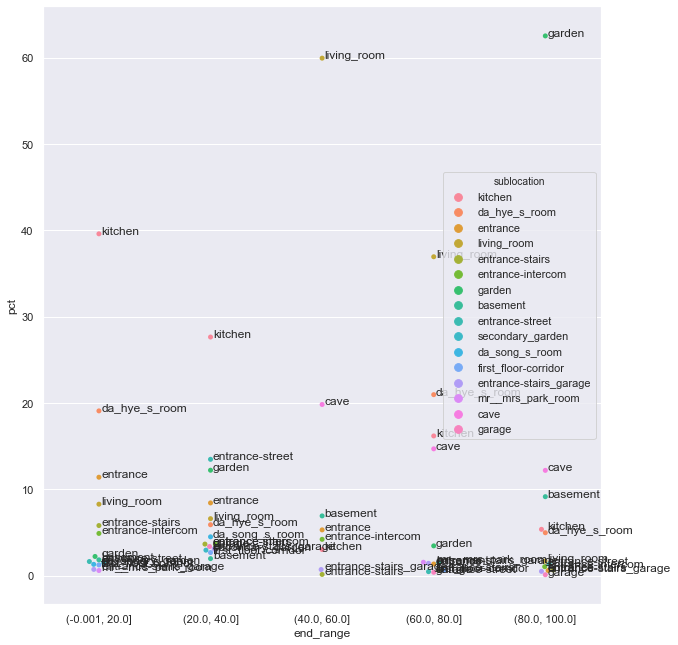

In [842]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10, 11)
label_point(check.end_range.cat.codes, check.pct, check.sublocation, ax)  

fig=sns.catplot(x="end_range", y="pct", hue="sublocation", kind="swarm",data=check,ax=ax,legend=False,legend_out=True);
plt.close(2);
#fig=sns.catplot(x="end_range", y="pct", hue="level", kind="swarm",data=check,ax=ax,legend=False);


In [830]:
#I am not able to save it
#fig.get_figure()
#fig.savefig('C:/Users/Javier San Miguel/Desktop/Data/Data visualization/Parasite/doc/img/roomocupation.jpg',dpi=200)

AttributeError: 'FacetGrid' object has no attribute 'get_figure'

# Characters Dataset

In [35]:
#ch.rename({"Link Image":"urlImage"},axis=1,inplace=True)
ch.dtypes
ch["id"]=ch["Character"].replace(" ",'_',regex=True)
ch.dropna(axis=0,subset=['urlImage'],inplace=True)

In [36]:
ch

,Character,Family,Actor,Role,urlImage,id
0,Ki Woo,Kim,Woo-sik Choi,English Teacher,https://github.com/javiersgdtu/javiersgvisual/...,Ki_Woo
1,Ki Jung,Kim,So-dam Park,Art Teacher,https://github.com/javiersgdtu/javiersgvisual/...,Ki_Jung
2,Ki Taek,Kim,Kang-ho Song,Chauffeur,https://github.com/javiersgdtu/javiersgvisual/...,Ki_Taek
3,Chung Sook,Kim,Hye-jin Jang,Housekeeper,https://raw.githubusercontent.com/javiersgdtu/...,Chung_Sook
4,Yeon Kyo,Park,Yeo-jeong Jo,Mother,https://github.com/javiersgdtu/javiersgvisual/...,Yeon_Kyo
5,Mr. Park,Park,Sun-kyun Lee,Father,https://github.com/javiersgdtu/javiersgvisual/...,Mr._Park
6,Da Hye,Park,Ji-so Jung,Daughter,https://github.com/javiersgdtu/javiersgvisual/...,Da_Hye
7,Da Song,Park,Hyun-jun Jung,Son,https://github.com/javiersgdtu/javiersgvisual/...,Da_Song
8,Moon Gwang,NaN,Jeong-eun Lee,First Housekeeper,https://github.com/javiersgdtu/javiersgvisual/...,Moon_Gwang
9,Geun Se,NaN,Myeong-hoon Park,First Housekeeper's husband,https://github.com/javiersgdtu/javiersgvisual/...,Geun_Se


In [37]:
ch.to_json("data_out/characters.json",orient='records');

# Deleted code

In [ ]:
#In 4. First method using the dissapeared locationid attribute =IF(E4=E3;D3;D3+1)
df_loc_gr=df_loc.groupby(["locationid","location"],as_index=False).agg({"Selection starts":"first","Selection ends":"last"})
df_loc_gr['difference_loc']=df_loc_gr['Selection ends']-df_loc_gr['Selection starts']
#df['difference_loc']=df['difference_loc'].dt.seconds
pd.set_option('display.max_rows', 73)
#df_loc_gr.difference_loc.sum() #To check whether the duration is similar to the film one.
df_loc_gr.head()

In [ ]:
df_loc_sum=df_loc_gr.groupby(["location"]).agg({"difference_loc":"sum"})
df_loc_sum["pct"] = df_loc_sum.apply(lambda x:100 * x / x.sum())

df_loc_sum.sort_values("difference_loc",ascending=False)

In [ ]:
#-------In the sublocation fields
#print(df_loc_filt.shape)
#Actually not really needed with the function used above.
#df_loc_filt_dup=df_loc_filt.drop_duplicates(subset=['locationid', 'sublocation','Selection starts','Selection ends'], keep='last')
#print(df_loc_filt_dup.shape)


In [ ]:
#First approach discarded: Create intervals
#df_loc_filt_dup["interval"]=[pd.Interval(j["Selection starts"],j["Selection ends"],closed='both') for i,j in df_loc_filt_dup.iterrows()]
#df_loc_filt_dup["interval"][46].overlaps(df_loc_filt_dup["interval"][47])
#df_loc_filt_dup.head(20)